## Pull data

Note: should probably add multiprocessing as this is very computationally expensive with a large dataset

#### from Lilian's code to pull csvs:

In [101]:
import requests
import pandas as pd
from io import BytesIO, StringIO
from zipfile import ZipFile

In [102]:
ais_csv_years = list(range(2015, 2018))
ais_csv_zone_numbers = list(range(1, 4))
ais_gdb_years = list(range(2009, 2015))
ais_gdb_misc = list(range(2011, 2014))
ais_gdb_zone = 10

tle_years = list(range(2004, 2019))
tle_misc = [2004]
tle_parts = list(range(1, 9))

In [103]:
class s3Import(object):
    def __init__(self):
        # Define files founds in s3 bucket
        self.ais_csv_names = ["AIS_" + str(year) + "_01_Zone0" + str(zone_num) + ".zip" for year in ais_csv_years for zone_num in ais_csv_zone_numbers]
        self.ais_gdb_names = ["Zone" + str(ais_gdb_zone) + "_" + str(year) + "_01.gdb.zip" if year in ais_gdb_misc else "Zone" + str(ais_gdb_zone) + "_" + str(year) + "_01.zip" for year in ais_gdb_years]
        self.tle = ["tle" + str(tle_misc[0]) + "_" + str(part) + "of" + str(tle_parts[-1]) + ".txt.zip" for part in tle_parts] + ["tle" + str(year) + ".txt.zip" for year in tle_years]
    
        self.aws_s3_env = "us-gov-west-1"
        self.bucket_name = "afdata"
        
        self.folder = "/Scenario_Data/"
        
    def read_ais_csv(self):
        ais_csv = pd.DataFrame()
        url = "https://" + self.bucket_name + ".s3-" + self.aws_s3_env + ".amazonaws.com"
        for csv in self.ais_csv_names:
            file_path = url + self.folder + "AIS/" + csv
            r = requests.get(file_path)
            # Unzip file
            filebytes = ZipFile(BytesIO(r.content))
            # Convert bytes into string
            df_string = StringIO(filebytes.read(filebytes.namelist()[0]).decode("utf-8"))
            df = pd.read_csv(df_string, sep=",")
            ais_csv = ais_csv.append(df, ignore_index=True)
            print("loaded", csv)
        return(ais_csv)

In [104]:
s3i = s3Import()

ais_csv = s3i.read_ais_csv()

loaded AIS_2015_01_Zone01.zip
loaded AIS_2015_01_Zone02.zip
loaded AIS_2015_01_Zone03.zip
loaded AIS_2016_01_Zone01.zip
loaded AIS_2016_01_Zone02.zip
loaded AIS_2016_01_Zone03.zip
loaded AIS_2017_01_Zone01.zip
loaded AIS_2017_01_Zone02.zip
loaded AIS_2017_01_Zone03.zip


In [105]:
ais_csv.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo
0,235091871,2015-01-01T00:08:26,52.78763,-175.62761,10.3,74.5,86.0,EVA BULKER,IMO9544164,2FJU4,70.0,under way using engine,185.0,31.0,6.6,70.0
1,247119100,2015-01-01T05:36:17,52.87994,-176.21738,10.7,-148.8,263.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0
2,247119100,2015-01-01T06:28:57,52.83234,-176.46662,11.0,-160.8,254.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0
3,247119100,2015-01-01T06:32:27,52.82851,-176.48291,11.0,-160.6,254.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0
4,247119100,2015-01-01T06:36:07,52.82446,-176.50022,11.0,-160.0,254.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0


In [8]:
ais_csv['Status'].value_counts()

under way using engine                   5502883
undefined                                1468552
engaged in fishing                       1003324
moored                                    333163
under way sailing                         280562
at anchor                                 150340
reserved for future use (10)               15522
not under command                           9719
restricted maneuverability                  8616
AIS-SART (active); MOB-AIS; EPIRB-AIS         10
constrained by her draught                     4
power-driven vessel towing astern              2
reserved for future use (13)                   1
reserved for future use (9)                    1
Name: Status, dtype: int64

<AxesSubplot:>

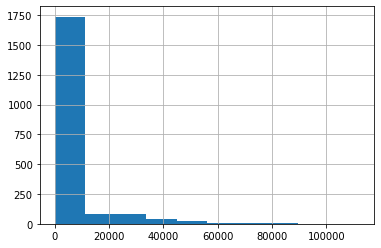

In [9]:
ais_csv['MMSI'].value_counts().hist()

In [106]:
import geopandas
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [107]:
gdf = geopandas.GeoDataFrame(
    ais_csv, geometry=geopandas.points_from_xy(ais_csv.LON, ais_csv.LAT))

In [108]:
gdf.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,geometry
0,235091871,2015-01-01T00:08:26,52.78763,-175.62761,10.3,74.5,86.0,EVA BULKER,IMO9544164,2FJU4,70.0,under way using engine,185.0,31.0,6.6,70.0,POINT (-175.62761 52.78763)
1,247119100,2015-01-01T05:36:17,52.87994,-176.21738,10.7,-148.8,263.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0,POINT (-176.21738 52.87994)
2,247119100,2015-01-01T06:28:57,52.83234,-176.46662,11.0,-160.8,254.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0,POINT (-176.46662 52.83234)
3,247119100,2015-01-01T06:32:27,52.82851,-176.48291,11.0,-160.6,254.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0,POINT (-176.48291 52.82851)
4,247119100,2015-01-01T06:36:07,52.82446,-176.50022,11.0,-160.0,254.0,POLE,IMO9128245,IBTE,70.0,under way using engine,224.0,32.0,-12.8,70.0,POINT (-176.50022 52.82446)


In [13]:
gdf.to_csv(r'gdf.csv') 

In [ ]:
#load csv if shortcut is needed
gdf = pd.read_csv('gdf.csv')
gdf = gpd.GeoDataFrame(gdf).set_geometry('geometry')

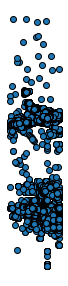

In [146]:
ax = gdf.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
ax.axis('off')


# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, edgecolor='k')

plt.show()

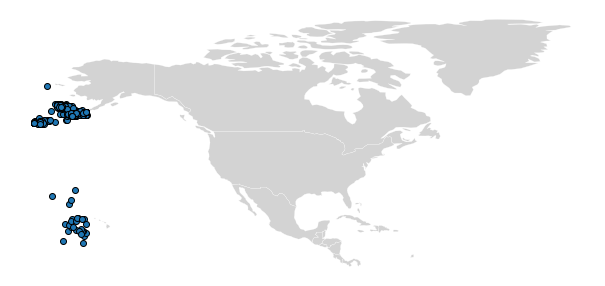

In [86]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
NoAm = world.query('continent == "North America"')
ax = NoAm.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
ax.axis('off')


# We can now plot our ``GeoDataFrame``.
gdf.head(10000).plot(ax=ax, edgecolor='k')

plt.show()

In [18]:
type(world)

geopandas.geodataframe.GeoDataFrame

In [109]:
mini_sample = gdf.head(10000)

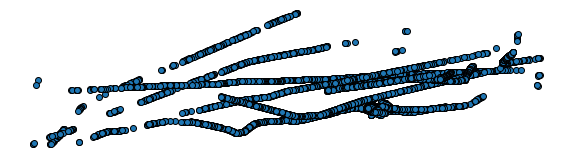

In [111]:
fig,ax = plt.subplots(figsize=(10,10))

# world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# ax = world.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
ax.axis('off')


# # We can now plot our ``GeoDataFrame``.
mini_sample.plot(ax=ax, edgecolor='k')

plt.show()

In [52]:
# convert to 3d?
# import pyproj

In [18]:
# wgs84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')##4326
# geocentric= pyproj.Proj('+proj=geocent +datum=WGS84 +units=m +no_defs') ##4978

# x2 , y2  , z2= pyproj.transform( wgs84, geocentric, x, y, z)

In [56]:
from shapely.geometry import Polygon

bounds = ((0,-179),(90,-179),(90,-100),(0,-100))
# bounds = ((0,-179),(1,1),(1,0),(0,1))
polygon = Polygon([[p[0], p[1]] for p in bounds])

print(polygon.wkt)  

POLYGON ((0 -179, 90 -179, 90 -100, 0 -100, 0 -179))


In [57]:
world_clipped = geopandas.clip(world, polygon)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


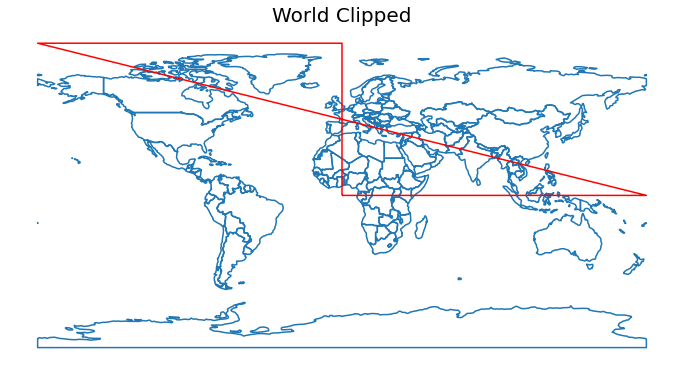

In [58]:
# Plot the clipped data
# The plot below shows the results of the clip function applied to the world
fig, ax = plt.subplots(figsize=(12, 8))
world_clipped.plot(ax=ax, color="purple")
world.boundary.plot(ax=ax)
poly_gdf.boundary.plot(ax=ax, color="red")
ax.set_title("World Clipped", fontsize=20)
ax.set_axis_off()
plt.show()

In [54]:
# TO DOs: 

# convert to 3d points?? use generic z since it doesn't matter??
# convert long/lat to WGS84?? verify compatibility !
# check for outliers ?


## cluster analysis

In [46]:
# not sure this part is relevant to our analytical needs

# ("Although routes are not often defined by any boundaries like a road network, they can be extracted by 
#   grouping similar positional vectors produced by a moving vessel over time, using an algorithm called 
#   clustering. Once routes have been defined by the clustering algorithm, a route of interest can be extracted 
#   and future vessel positions can be predicted based on the route characteristics.")



### algorithm 1: DBSCAN

In [7]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

Automatically created module for IPython interactive environment


In [95]:
# #############################################################################
# Format data 
X = gdf[['LON', 'LAT']].to_numpy()
print(len(X))

9088555


In [113]:
X_mini = mini_sample[['LON', 'LAT']].to_numpy()
X_mini

array([[-175.62761,   52.78763],
       [-176.21738,   52.87994],
       [-176.46662,   52.83234],
       ...,
       [-175.95383,   52.13117],
       [-175.95563,   52.13672],
       [-175.95425,   52.1417 ]])

In [96]:
X

array([[-175.62761,   52.78763],
       [-176.21738,   52.87994],
       [-176.46662,   52.83234],
       ...,
       [-166.61428,   53.94957],
       [-166.61357,   53.94916],
       [-166.61356,   53.94912]])

In [97]:
type(X)

numpy.ndarray

In [98]:
X.shape

(9088555, 2)

In [115]:
# save array as .txt 
np.savetxt("data_for_clustering.csv", X, delimiter=",")

In [2]:
# read array data as shortcut if needed 
import pandas as pd
X = pd.read_csv("data_for_clustering.csv", header=None)
X = X.values

In [4]:
print(type(X))

<class 'numpy.ndarray'>


In [5]:
X

array([[-175.62761,   52.78763],
       [-176.21738,   52.87994],
       [-176.46662,   52.83234],
       ...,
       [-166.61428,   53.94957],
       [-166.61357,   53.94916],
       [-166.61356,   53.94912]])

In [15]:
# create sample to avoid crashing?
X_sample = X[np.random.choice(X.shape[0], 10000, replace=False), :]
X_sample

array([[-166.5545 ,   53.86925],
       [-166.53964,   53.88019],
       [-166.54147,   53.87915],
       ...,
       [-166.53918,   53.87917],
       [-169.88403,   56.44918],
       [-162.3261 ,   55.05473]])

In [16]:
len(X_sample)

10000

In [134]:
# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(X_sample)

In [135]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
db

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [136]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [137]:
print(n_clusters_)
print(n_noise_)

8
80


In [ ]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

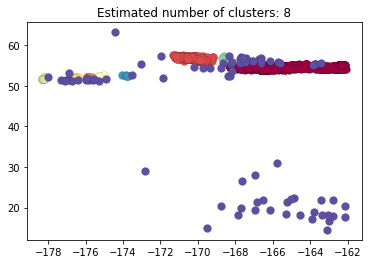

In [138]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)    # {-1, 0, 1, 2, 3, 4, 5, 6, 7}
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
#     if k == -1:
#         # Black used for noise.
#         col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_sample[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markeredgewidth=0.1, markersize=8)

#     xy = X_sample[class_member_mask & ~core_samples_mask]
#     plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
#              markeredgecolor='k', markersize=3)

plt.title('Estimated number of clusters: %d' % n_clusters_)

plt.show()

17


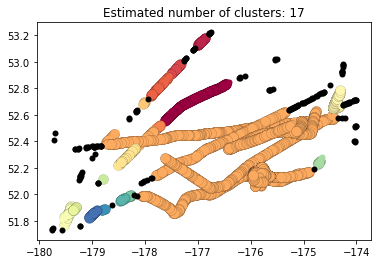

In [132]:
# with first 10k rows:
db = DBSCAN(eps=0.05, min_samples=10).fit(X_mini)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
(print(n_clusters_))

# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_mini[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markeredgewidth=0.1, markersize=10)

    xy = X_mini[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
         markeredgewidth=0.0, markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [69]:
len(X_sample)

10000

In [72]:
# create geodf of array's X and Y vals
x = list()
y = list()
for i in range(X_sample.shape[0]):
    x.append(X_sample[i][0])
for i in range(X_sample.shape[0]):
    y.append(X_sample[i][1])

In [88]:
# make df: 
clusters_df = pd.DataFrame(list(zip(x,y)), columns=['LON','LAT'])

clusters_gdf = geopandas.GeoDataFrame(
    clusters_df, geometry=geopandas.points_from_xy(clusters_df.LON, clusters_df.LAT))

In [90]:
clusters_gdf.head()

,LON,LAT,geometry
0,-166.55450,53.86925,POINT (-166.55450 53.86925)
1,-166.53964,53.88019,POINT (-166.53964 53.88019)
2,-166.54147,53.87915,POINT (-166.54147 53.87915)
3,-166.52933,53.90183,POINT (-166.52933 53.90183)
4,-166.75536,54.04010,POINT (-166.75536 54.04010)


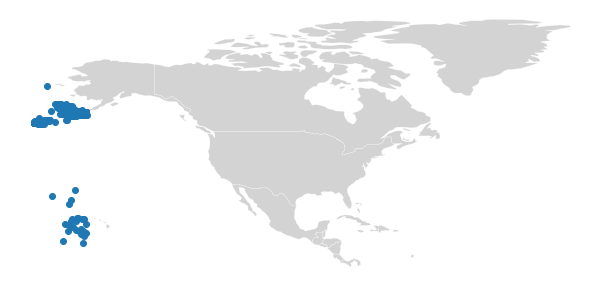

In [91]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
NoAm = world.query('continent == "North America"')
ax = NoAm.plot(figsize=(20,5), linewidth=0.25, edgecolor='white', color='lightgrey')
ax.axis('off')

clusters_gdf.plot(ax=ax)

plt.show()

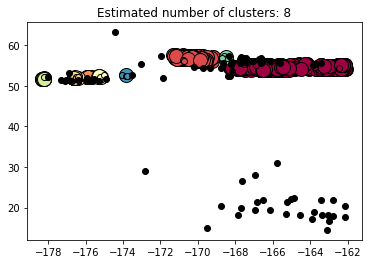

In [95]:
# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_sample[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_sample[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

### Algorithm 2: OPTICS

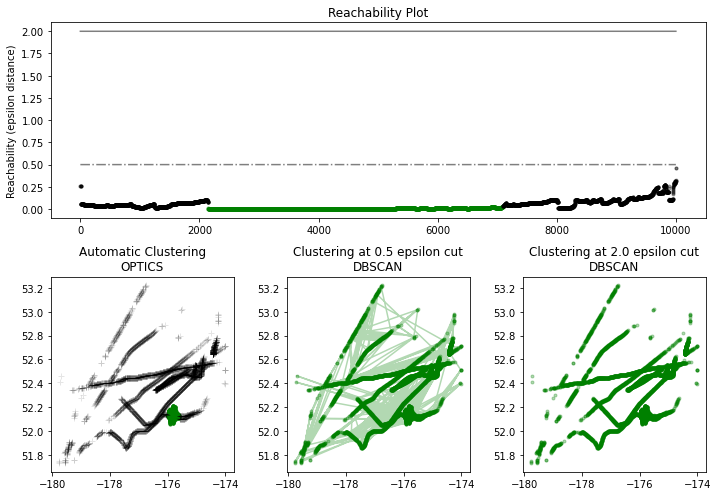

In [145]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

# C1 = [-5, -2] + .8 * np.random.randn(n_points_per_cluster, 2)
# C2 = [4, -1] + .1 * np.random.randn(n_points_per_cluster, 2)
# C3 = [1, -2] + .2 * np.random.randn(n_points_per_cluster, 2)
# C4 = [-2, 3] + .3 * np.random.randn(n_points_per_cluster, 2)
# C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
# C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
# X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)

# Run the fit
clust.fit(X_mini)

labels_050 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=0.5)
labels_200 = cluster_optics_dbscan(reachability=clust.reachability_,
                                   core_distances=clust.core_distances_,
                                   ordering=clust.ordering_, eps=2)

space = np.arange(len(X_mini))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], 'k.', alpha=0.3)
ax1.plot(space, np.full_like(space, 2., dtype=float), 'k-', alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), 'k-.', alpha=0.5)
ax1.set_ylabel('Reachability (epsilon distance)')
ax1.set_title('Reachability Plot')

# OPTICS
colors = ['g.', 'r.', 'b.', 'y.', 'c.']
for klass, color in zip(range(0, 5), colors):
    Xk = X_mini[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X_mini[clust.labels_ == -1, 0], X_mini[clust.labels_ == -1, 1], 'k+', alpha=0.1)
ax2.set_title('Automatic Clustering\nOPTICS')

# DBSCAN at 0.5
colors = ['g', 'greenyellow', 'olive', 'r', 'b', 'c']
for klass, color in zip(range(0, 6), colors):
    Xk = X_mini[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker='.')
ax3.plot(X_mini[labels_050 == -1, 0], X_mini[labels_050 == -1, 1], 'k+', alpha=0.1)
ax3.set_title('Clustering at 0.5 epsilon cut\nDBSCAN')

# DBSCAN at 2.
colors = ['g.', 'm.', 'y.', 'c.']
for klass, color in zip(range(0, 4), colors):
    Xk = X_mini[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X_mini[labels_200 == -1, 0], X_mini[labels_200 == -1, 1], 'k+', alpha=0.1)
ax4.set_title('Clustering at 2.0 epsilon cut\nDBSCAN')

plt.tight_layout()
plt.show()

In [ ]:
# dendrogram/refining.....